In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 

In [63]:
## Loading the dataset
df = pd.read_csv('test.csv')
df.head()

,sample_id,catalog_content,image_link
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...
1,245611,Item Name: Natural MILK TEA Flavoring extract ...,https://m.media-amazon.com/images/I/61ex8NHCIj...
2,146263,Item Name: Honey Filled Hard Candy - Bulk Pack...,https://m.media-amazon.com/images/I/61KCM61J8e...
3,95658,Item Name: Vlasic Snack'mm's Kosher Dill 16 Oz...,https://m.media-amazon.com/images/I/51Ex6uOH7y...
4,36806,"Item Name: McCormick Culinary Vanilla Extract,...",https://m.media-amazon.com/images/I/71QYlrOMoS...


In [64]:
## Checking for null values
df.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
dtype: int64

In [65]:
## Checking for duplicated values
df.duplicated().sum()

0

### Code with a Smart IPQ Parser

- Here, we're trying to extract *key features* from the 'catalog_content'
    - product_name → Extracted from “Item Name:” section.

    - product_description → Formed by joining all bullet points.

    - quantity and unit → Extracted using smart regex (e.g., “500 ml” → 500, milliliter)

The idea is to clean & normalize units so different spellings (like “ml”, “mililitro”) become one standard form (like milliliter)

In [ ]:
import pandas as pd
import re
import numpy as np

# Define Unit Normalization Mappings (No changes here)
UNIT_ALIASES = {
    'count': ['count', 'ct', 'each', 'pack', 'packs', 'piece', 'units', 'capsule'],
    'ounce': ['ounce', 'ounces', 'oz'],
    'fluid_ounce': ['fl', 'fluid'],
    'pound': ['pound', 'pounds', 'lb'],
    'gram': ['gram', 'grams', 'gr', 'gramm'],
    'kilogram': ['kg', 'kilogram'],
    'liter': ['liter', 'liters', 'ltr'],
    'milliliter': ['ml', 'milliliter', 'millilitre', 'mililitro']
}
NORMALIZED_UNIT_MAP = {alias: standard_name for standard_name, aliases in UNIT_ALIASES.items() for alias in aliases}
ALL_UNITS_REGEX = '|'.join(NORMALIZED_UNIT_MAP.keys())


# Create the Smarter IPQ Parsing Function (No changes here)
def parse_and_clean_ipq(text):
    """
    Intelligently extracts and normalizes quantity and unit from text.
    """
    value_unit_match = re.search(r'Value:\s*([\d.]+)\s*Unit:\s*(\w+)', text, flags=re.IGNORECASE)
    if value_unit_match:
        try:
            found_unit = value_unit_match.group(2).lower()
            if found_unit in NORMALIZED_UNIT_MAP:
                return float(value_unit_match.group(1)), NORMALIZED_UNIT_MAP[found_unit]
        except (ValueError, TypeError):
            pass

    general_match = re.search(r'(\d*\.?\d+)\s*\-?\s*(' + ALL_UNITS_REGEX + r')\b', text, flags=re.IGNORECASE)
    if general_match:
        try:
            return float(general_match.group(1)), NORMALIZED_UNIT_MAP[general_match.group(2).lower()]
        except (ValueError, TypeError):
            pass

    return np.nan, 'unknown'


# Update the Main Feature Extraction Function (With Fallback Logic)
def extract_product_details_with_fallback(df):
    """
    The main function with robust extractors and a fallback for the description.
    """
    
    df['product_name'] = df['catalog_content'].str.extract(
        r'Item Name:(.*?)(?=Bullet Point \d+:|Value:|$)', flags=re.DOTALL
    )[0].fillna('').str.strip()
    
    # Step 2: Extract Description from Bullet Points
    def combine_bullets_final(content):
        bullets = re.findall(r'Bullet Point \d+:(.*?)(?=Bullet Point \d+:|Value:|$)', content, flags=re.DOTALL)
        if not bullets:
            return "" # Return empty string if no bullets are found
        return ' '.join([bullet.strip() for bullet in bullets if bullet.strip()])

    df['product_description'] = df['catalog_content'].apply(combine_bullets_final)

    # *** THE FALLBACK LOGIC ***
    # Find rows where the description is still an empty string
    empty_desc_mask = df['product_description'] == ''
    
    # For those rows, we will set the description to be the product name
    df.loc[empty_desc_mask, 'product_description'] = df.loc[empty_desc_mask, 'product_name']

    # Step 3: Extract IPQ (No changes here)
    ipq_data = df['catalog_content'].apply(lambda x: pd.Series(parse_and_clean_ipq(x)))
    df[['quantity', 'unit']] = ipq_data
    df['quantity'] = df['quantity'].fillna(0)
    df['unit'] = df['unit'].fillna('unknown')
    
    return df


# Apply the final, fully corrected function
df_processed = extract_product_details_with_fallback(df.copy())

# Proof of the Fix
print("Fallback logic applied.")

# Check for any remaining empty descriptions (should be 0)
empty_descriptions_after_fix = (df_processed['product_description'] == '').sum()
print(f"Number of empty descriptions after fix: {empty_descriptions_after_fix}")


Fallback logic applied.
Number of empty descriptions after fix: 4


### Removing the 5 rows with no description (don't remove)

In [67]:
empty_list = []
index_list = []
for i in range(df_processed.shape[0]):
    if(df_processed['product_description'][i] == ''):
        empty_list.append(df_processed['sample_id'][i])
        index_list.append(i)

print(empty_list)
print(index_list)

[50844, 87303, 271976, 89935]
[47329, 55240, 60840, 61088]


In [68]:
# df_processed.drop(index=[41520, 50513, 50543, 55110, 74234], inplace=True)

In [69]:
df_processed.head(1)

,sample_id,catalog_content,image_link,product_name,product_description,quantity,unit
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...,Rani 14-Spice Eshamaya's Mango Chutney (Indian...,You'll LOVE our 14-Spice Eshamaya's Mango Chut...,10.5,ounce


In [70]:
df_processed['unit'].unique()

array(['ounce', 'fluid_ounce', 'count', 'unknown', 'pound', 'milliliter',
       'gram', 'kilogram', 'liter'], dtype=object)

### Feature Engineering Techniques

1. We will use *Basic Text Statistics* for this part. Creating 3 new features:
 - name_length: no. of characters in *product_name*
 - desc_word_count: Number of words in the *product_description*
 - desc_uniqueness: Ratio of unique words to total words in the description.
    

In [ ]:
df_processed['name_length'] = df_processed['product_name'].str.len()
df_processed['desc_word_count'] = df_processed['product_description'].str.split().str.len()
df_processed['desc_uniqueness'] = df_processed['product_description'].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-6))

In [72]:
df_processed.head(1)

,sample_id,catalog_content,image_link,product_name,product_description,quantity,unit,name_length,desc_word_count,desc_uniqueness
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...,Rani 14-Spice Eshamaya's Mango Chutney (Indian...,You'll LOVE our 14-Spice Eshamaya's Mango Chut...,10.5,ounce,137,163,0.766871


In [73]:
df_processed.isnull().sum()

sample_id              0
catalog_content        0
image_link             0
product_name           0
product_description    0
quantity               0
unit                   0
name_length            0
desc_word_count        0
desc_uniqueness        0
dtype: int64

In [74]:
list = [df_processed['unit'].unique()]
print(list)

[array(['ounce', 'fluid_ounce', 'count', 'unknown', 'pound', 'milliliter',
       'gram', 'kilogram', 'liter'], dtype=object)]


### Standardizing the Units

- To compare products, their quantities must be in the same unit. So, we will create a single, standardized quantity column.

In [ ]:
def standardize_units_and_value(df, quantity_col='quantity', unit_col='unit'):
   
    
    # Conversion factors to standard units (kg for mass, L for volume)
    conversion_map = {
        # Mass to Kilograms (kg)
        'ounce': 0.0283495,
        'pound': 0.453592,
        'gram': 0.001,
        'kilogram': 1.0,
        
        # Volume to Liters (L)
        'fluid_ounce': 0.0295735,
        'milliliter': 0.001,
        'liter': 1.0
    }
    
    # Function to apply to each row
    def convert_row(row):
  
        unit = str(row[unit_col]).lower()
        
        if unit in conversion_map:
            # Get the conversion factor
            factor = conversion_map[unit]
            
            # Calculate the new quantity
            new_quantity = row[quantity_col] * factor
            
            # Determine the new standard unit
            new_unit = 'kg' if unit in ['ounce', 'pound', 'gram', 'kilogram'] else 'L'
            
            return new_quantity, new_unit
        else:
            # If the unit is not in the map (e.g., 'count', 'unknown'),
            # return the original values
            return row[quantity_col], row[unit_col]

    # Apply the function and create new columns
    # Apply the function row-wise (axis=1) and expand the result into two new columns
    df[['standardized_quantity', 'standardized_unit']] = df.apply(convert_row, axis=1, result_type='expand')
    
    return df

In [76]:
df_processed = standardize_units_and_value(df_processed)

In [77]:
df_processed.head(1)

,sample_id,catalog_content,image_link,product_name,product_description,quantity,unit,name_length,desc_word_count,desc_uniqueness,standardized_quantity,standardized_unit
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...,Rani 14-Spice Eshamaya's Mango Chutney (Indian...,You'll LOVE our 14-Spice Eshamaya's Mango Chut...,10.5,ounce,137,163,0.766871,0.29767,kg


### Dropping *quantity* & *unit*

In [78]:
df_processed = df_processed.drop(columns=['quantity', 'unit'])

In [79]:
df_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
sample_id,75000.0,149387.988880,86763.376732,1.0,73760.500000,149109.500000,224529.750000,299439.0
name_length,75000.0,120.914400,164.751481,0.0,56.000000,79.000000,141.000000,3802.0
desc_word_count,75000.0,120.068387,127.513908,0.0,23.000000,73.000000,170.000000,1887.0
desc_uniqueness,75000.0,0.784993,0.156698,0.0,0.674184,0.791209,0.916667,1.0
standardized_quantity,75000.0,13.629944,482.794184,0.0,0.340194,0.946352,3.000000,120000.0


### Insights

- The dataset is skewed as the std of the price is quite *high* with std of 25.196702 & min of 0.1300000

### Heatmap --> To identify the correlation between between the features

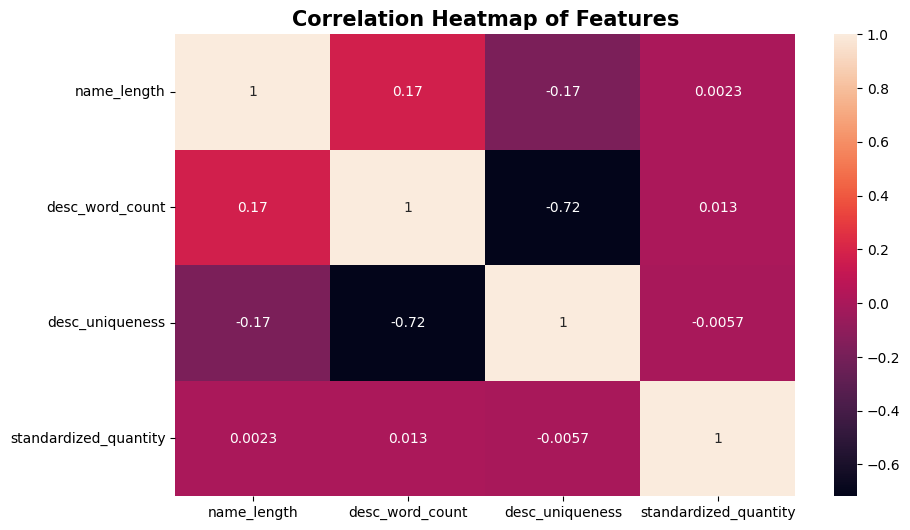

In [80]:
plt.figure(figsize=[10, 6])
sns.heatmap(data=df_processed[[
       'name_length', 'desc_word_count',
       'desc_uniqueness', 'standardized_quantity']].corr(), annot=True)
plt.title("Correlation Heatmap of Features", fontsize=15, weight='bold')
plt.show()

### Insights

- There's no strong correlation between the features. So we can keep the features.

### Boxplot --> To detect outliers

Text(0.5, 1.0, 'standardized quantity')

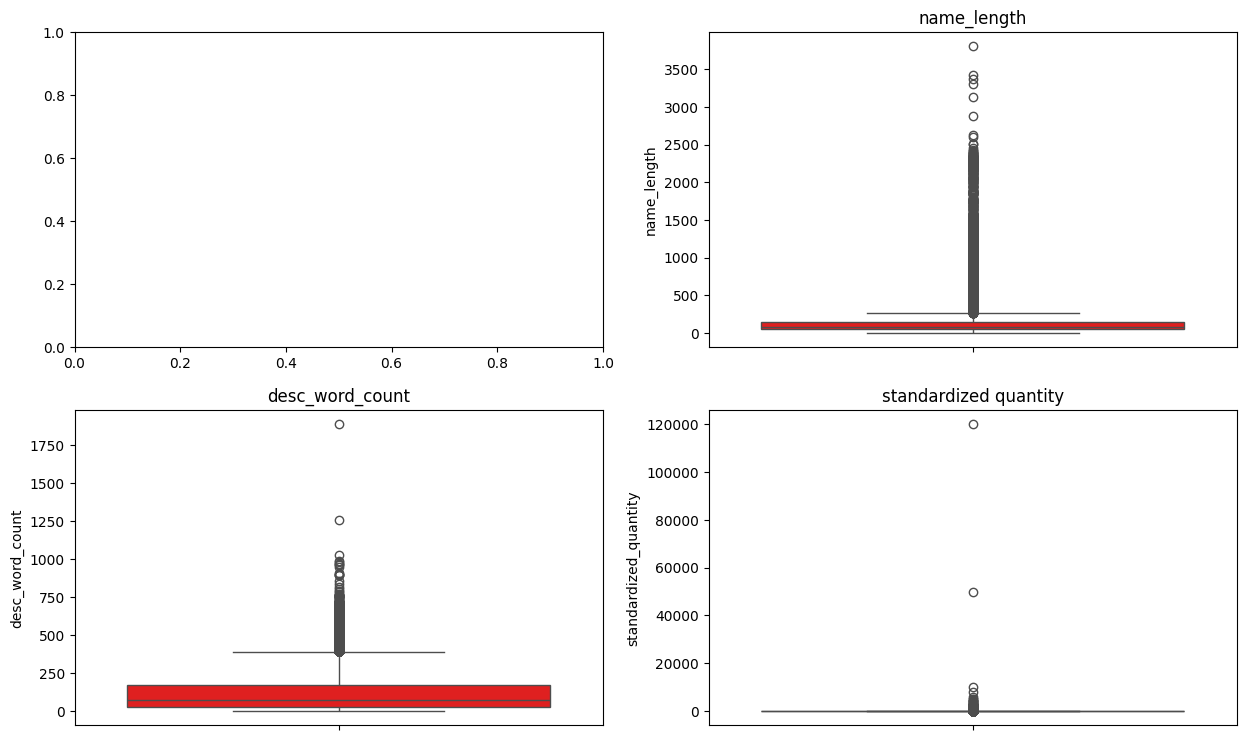

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))


## Plot 2: name_length
sns.boxplot(y=df_processed['name_length'], ax=axs[0, 1], color='r')
axs[0, 1].set_title('name_length')


## Plot 3: desc_word_count
sns.boxplot(y=df_processed['desc_word_count'], ax=axs[1, 0], color='r')
axs[1, 0].set_title('desc_word_count')

## Plot 4: standardized_quantity
sns.boxplot(y=df_processed['standardized_quantity'], ax=axs[1, 1], color='r')
axs[1, 1].set_title('standardized quantity')



### Insights

### Histograms

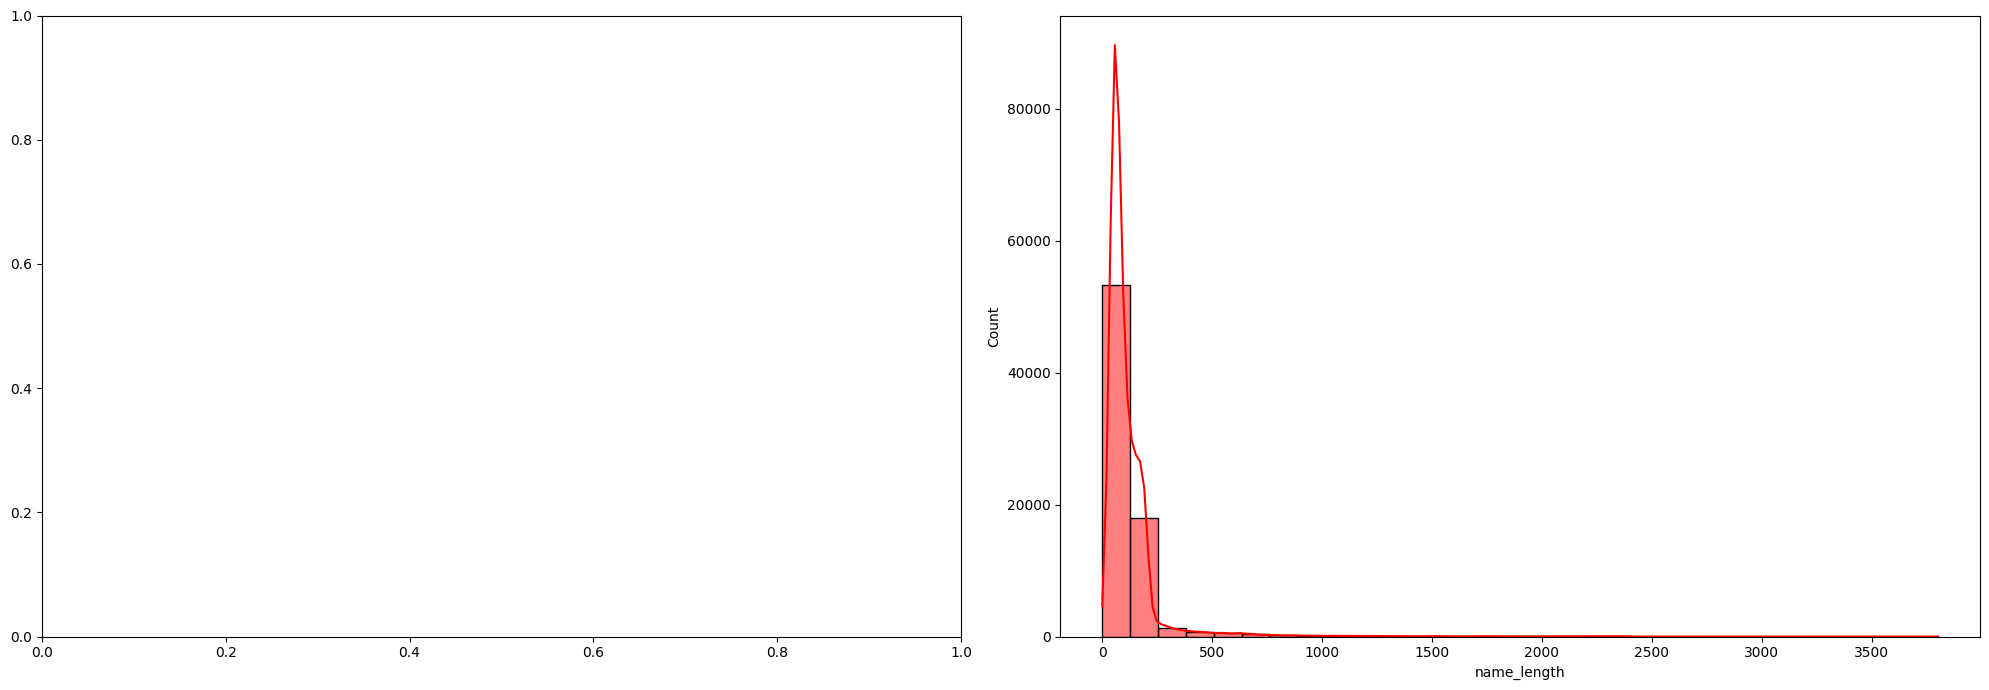

In [30]:
fig, axs = plt.subplots(1, 2, figsize=[20,7])
plt.subplot(1,2,2)
sns.histplot(data=df_processed['name_length'], bins=30, kde=True, color='r')
plt.tight_layout()
plt.show()

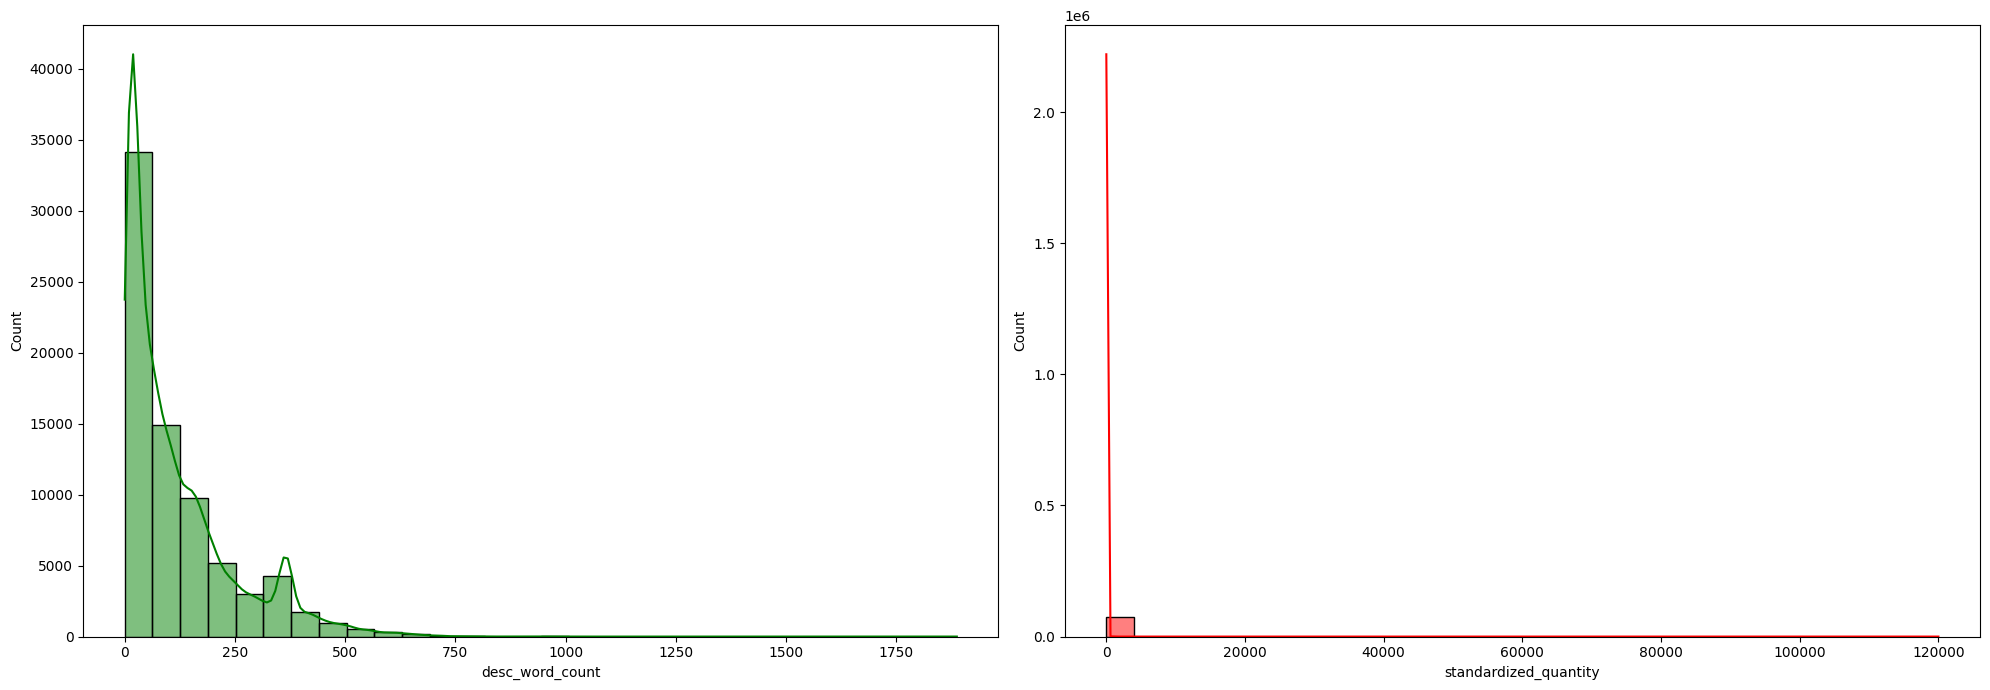

In [31]:
fig, axs = plt.subplots(1, 2, figsize=[20,7])
plt.subplot(1,2,1)
sns.histplot(data=df_processed['desc_word_count'], bins=30, kde=True, color='g')
plt.subplot(1,2,2)
sns.histplot(data=df_processed['standardized_quantity'], bins=30, kde=True, color='r')
plt.tight_layout()
plt.show()

### Insights
- The dataset is a lot skewed. So we will have to apply 'Log-Transformation' to change the distribution of the 'Normal-distribution'.

# Violinplot

- A violin plot is used to visualize the distribution, density, and probability density function (PDF) of a dataset, combining aspects of a box plot and a kernel density plot.

Text(0.5, 1.0, 'standardized quantity')

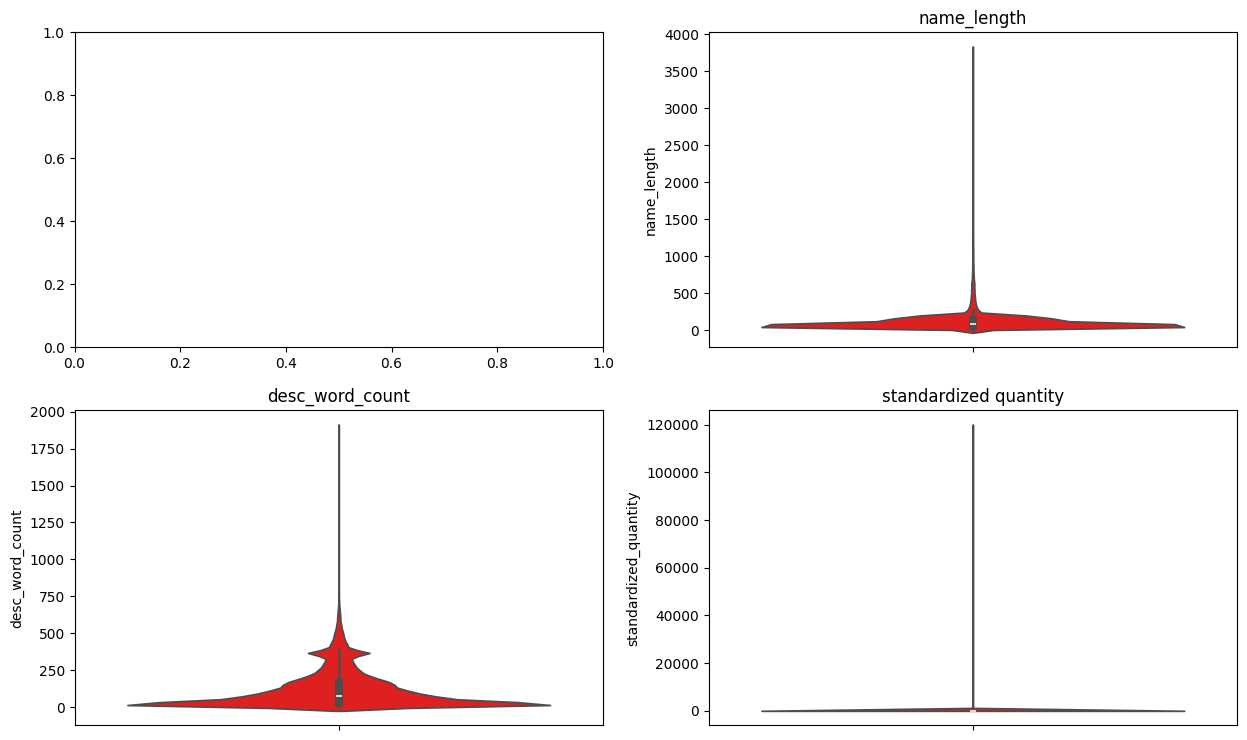

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

## Plot 1: Price
# sns.violinplot(y=df_processed['price'], ax=axs[0, 0], color='r')
# axs[0, 0].set_title('Price')

## Plot 2: name_length
sns.violinplot(y=df_processed['name_length'], ax=axs[0, 1], color='r')
axs[0, 1].set_title('name_length')


## Plot 3: desc_word_count
sns.violinplot(y=df_processed['desc_word_count'], ax=axs[1, 0], color='r')
axs[1, 0].set_title('desc_word_count')

## Plot 4: standardized_quantity
sns.violinplot(y=df_processed['standardized_quantity'], ax=axs[1, 1], color='r')
axs[1, 1].set_title('standardized quantity')



### Creating a copy dataframe

In [33]:
df_copy = df_processed.copy()

In [34]:
df_copy.shape

(75000, 10)

### Checking for skew

In [35]:
# df_processed['price'].skew()

In [36]:
df_processed['name_length'].skew()

7.615285010636891

In [37]:
df_processed['desc_word_count'].skew()

1.599402646681839

In [38]:
df_processed['standardized_quantity'].skew()

219.78686955150124

In [39]:
df_processed.columns

Index(['sample_id', 'catalog_content', 'image_link', 'product_name',
       'product_description', 'name_length', 'desc_word_count',
       'desc_uniqueness', 'standardized_quantity', 'standardized_unit'],
      dtype='object')

### Applying Log Transformation on the columns

In [40]:
skewed_features = ['name_length', 'desc_word_count', 'standardized_quantity'] # Add 'quantity' if you haven't already

print("Skewness before transformation:")
print(df_processed[skewed_features].skew())

# Apply the log transformation, creating new columns
for feature in skewed_features:
    df_processed[f'{feature}_log'] = np.log1p(df_processed[feature])


df_processed = df_processed.drop(columns=skewed_features)

print("\nSkewness after transformation:")
print(df_processed[[f'{feature}_log' for feature in skewed_features]].skew())

Skewness before transformation:
name_length                7.615285
desc_word_count            1.599403
standardized_quantity    219.786870
dtype: float64

Skewness after transformation:
name_length_log              0.888456
desc_word_count_log         -0.204498
standardized_quantity_log    1.843764
dtype: float64


In [41]:
df_processed.head(1)

,sample_id,catalog_content,image_link,product_name,product_description,desc_uniqueness,standardized_unit,name_length_log,desc_word_count_log,standardized_quantity_log
0,100179,Item Name: Rani 14-Spice Eshamaya's Mango Chut...,https://m.media-amazon.com/images/I/71hoAn78AW...,Rani 14-Spice Eshamaya's Mango Chutney (Indian...,You'll LOVE our 14-Spice Eshamaya's Mango Chut...,0.766871,kg,4.927254,5.099866,0.26057


Text(0.5, 1.0, 'standardized quantity')

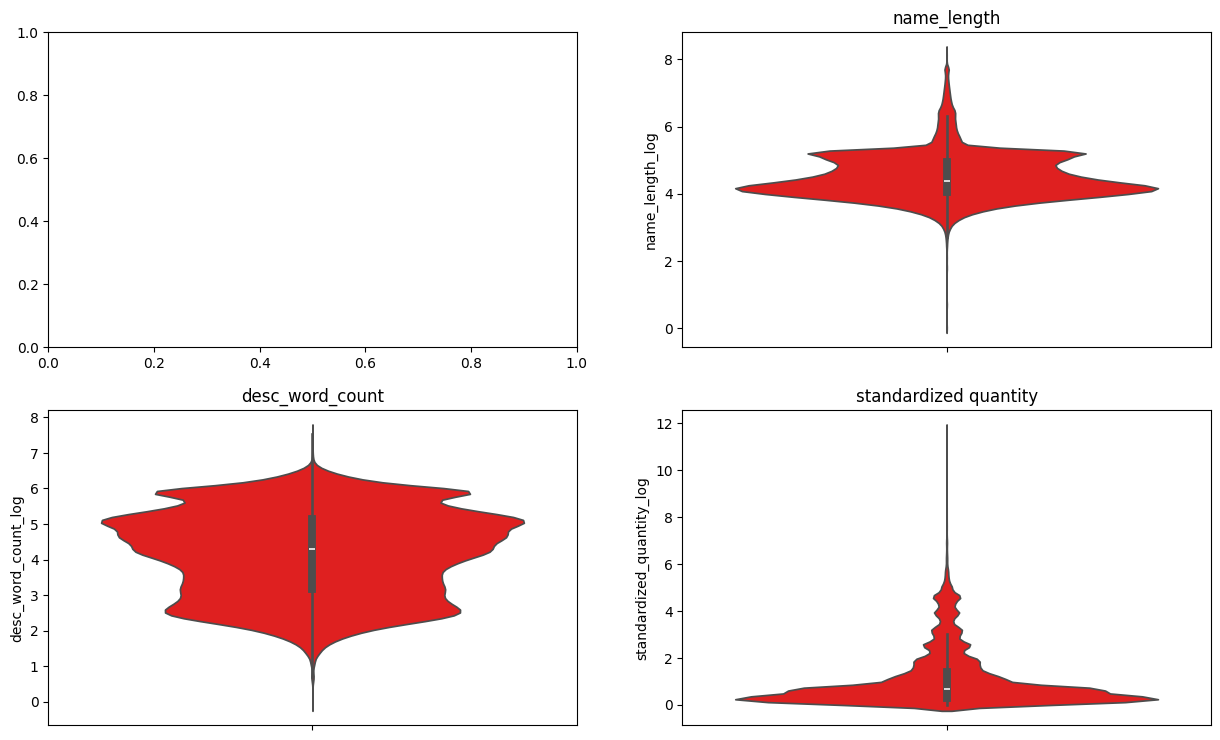

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

## Plot 1: Price
# sns.violinplot(y=df_processed['price_log'], ax=axs[0, 0], color='r')
# axs[0, 0].set_title('Price')

## Plot 2: name_length
sns.violinplot(y=df_processed['name_length_log'], ax=axs[0, 1], color='r')
axs[0, 1].set_title('name_length')


## Plot 3: desc_word_count
sns.violinplot(y=df_processed['desc_word_count_log'], ax=axs[1, 0], color='r')
axs[1, 0].set_title('desc_word_count')

## Plot 4: standardized_quantity
sns.violinplot(y=df_processed['standardized_quantity_log'], ax=axs[1, 1], color='r')
axs[1, 1].set_title('standardized quantity')



### Insights
- The skewness is finally reduced.

### Dropping *sample_id*, *image_link* & *product_name* columns

In [43]:
df_processed.drop(columns=['sample_id', 'catalog_content', 'image_link', 'product_name'], inplace=True)

In [44]:
# X = df_processed.drop(columns=['price_log'])
# y = df_processed['price_log']

In [46]:
X = df_processed.copy()

In [49]:
X.shape

(75000, 6)

### Label Encoding the *unit* column

In [50]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X['standardized_unit'] = encoder.fit_transform(X['standardized_unit'])

### Applying NLP preprocessing --> tokenization, removing stopwords, applying Stemming

In [56]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# One-time NLTK downloads (if you haven't already)
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Initialize the stemmer and get the list of stop words
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
def tokenize_stem_and_filter(text: str):
    """
    This function takes raw text and performs the following:
    1. Converts to lowercase.
    2. Removes punctuation and numbers.
    3. Tokenizes the text into words.
    4. Removes common English stop words.
    5. Stems each word to its root form.
    
    Returns a list of processed tokens.
    """
    if not isinstance(text, str):
        return []
    
    # Lowercase and remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter stop words and apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return stemmed_tokens

### Converting the textual data (product_name and product_description) into *word embeddings*

- Approach 1: Using Word2Vec

In [58]:
X.columns

Index(['product_description', 'desc_uniqueness', 'standardized_unit',
       'name_length_log', 'desc_word_count_log', 'standardized_quantity_log'],
      dtype='object')

In [ ]:
from tqdm import tqdm
def create_document_vector(tokens, model):
    """
    Averages the word vectors for a given list of tokens.
    Uses the trained Word2Vec model to look up vectors.
    """

    vectors = [model.wv[word] for word in tokens if word in model.wv.key_to_index]
    
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
        
    # else, return the mean of the vectors
    return np.mean(vectors, axis=0)

# Process Text and Train Word2Vec Model

# Preparing Text for Word2Vec
print("Processing product descriptions...")

processed_descriptions = [tokenize_stem_and_filter(text) for text in tqdm(X['product_description'].dropna())]

# Training the Word2Vec Model
print("\nTraining Word2Vec model...")
w2v_model = Word2Vec(
    sentences=processed_descriptions,
    vector_size=200,  # Number of dimensions of the word vectors.
    window=5,         
    min_count=2,      
    workers=4         
)
print("Word2Vec model trained!")

# We will create Document Vectors ---
print("\nCreating document vectors from descriptions...")
X_embed = np.array([create_document_vector(tokens, w2v_model) for tokens in processed_descriptions])

# Combine All Features
other_features = X[['desc_uniqueness', 'standardized_unit',
       'name_length_log', 'desc_word_count_log', 'standardized_quantity_log']].values

X_full_final = np.hstack([X_embed, other_features])

print("\nFinal matrix created successfully!")
print(f"Shape of the final training data matrix: {X_full_final.shape}")

Processing product descriptions...


100%|██████████| 75000/75000 [01:00<00:00, 1229.76it/s]



Training Word2Vec model...
✅ Word2Vec model trained!

Creating document vectors from descriptions...

✅ Final matrix created successfully!
Shape of the final training data matrix: (75000, 205)


In [60]:
X_full_final.shape

(75000, 205)

### Combining again the *X_full_final* & *sample_id* 

- 1. Create a new DataFrame from your final embedding vector array.
- 2. It's crucial to use the sample_id to ensure alignment.
- 3. We will create generic column names for the embeddings like 'embed_0', 'embed_1', etc.

In [ ]:
embedding_df = pd.DataFrame(
    X_full_final,
    index=df_copy['sample_id'], 
    columns=[f'embed_{i}' for i in range(X_full_final.shape[1])]
)

embedding_df.to_csv('text_embeddings_for_test.csv')

print(" Successfully created DataFrame with sample_id as the index!")
print("Shape of the final DataFrame:", embedding_df.shape)
print("\nHere's a preview of the resulting DataFrame:")
display(embedding_df.head())

✅ Successfully created DataFrame with sample_id as the index!
Shape of the final DataFrame: (75000, 205)

Here's a preview of the resulting DataFrame:


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_195,embed_196,embed_197,embed_198,embed_199,embed_200,embed_201,embed_202,embed_203,embed_204
sample_id,,,,,,,,,,,,,,,,,,,,,
100179,0.167129,0.051509,0.130709,-0.134972,-0.877971,0.229116,-0.178402,0.026596,-0.428483,0.295701,...,-0.381659,0.563845,0.435355,0.394184,-0.153561,0.766871,2.0,4.927254,5.099866,0.260570
245611,0.042100,-0.465889,-0.077660,0.290871,-0.709341,0.071417,-0.261035,-0.245988,0.140907,0.170986,...,-0.570599,-0.152343,0.044879,0.298177,-0.252614,0.687204,0.0,5.384495,5.356586,0.057464
146263,-0.430163,-0.166472,-0.083244,-0.081839,-0.601001,0.327443,-0.091514,-0.236976,-0.421445,-0.190189,...,-0.106788,-0.700941,0.118015,-0.015786,-0.250874,0.772277,2.0,4.219508,4.624973,0.645628
95658,0.287502,-0.800975,-0.603793,0.028293,-0.014921,0.453964,0.378289,-0.214673,0.915975,0.378323,...,0.418935,-0.046037,0.374031,0.436551,0.271158,1.000000,1.0,3.871201,2.302585,1.098612
36806,0.006771,-0.474150,-0.157202,0.128213,-0.779121,0.032438,-0.025936,-0.385653,-0.359042,-0.002878,...,-0.729474,-0.081829,-0.132260,0.582867,-0.249993,0.681319,0.0,5.236442,5.209486,0.665957


### Commenting out the remaining part --> the purpose was to generate only the vector embeddings for the 

### Splitting the data into training and test set


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_full_final, y, test_size=0.20, random_state=42)
# X_train.shape, X_test.shape

((59757, 205), (14940, 205))

### Evaluation Metric: SMAPE Function

- let's define the competition's evaluation metric, SMAPE, so we can use it for all our models.

In [ ]:
# def smape(y_true, y_pred):
#     """
#     Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
#     """
#     numerator = np.abs(y_pred - y_true)
#     denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
#     return np.mean(numerator / denominator) * 100

In [ ]:
# from tqdm import tqdm
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor


# from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

In [4]:
# models = {
#     "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42),
#     "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
#     "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
#     "LightGBM": LGBMRegressor(random_state=42, verbosity=-1, n_jobs=-1),
#     "Extra Trees": ExtraTreesRegressor(random_state=42, n_jobs=-1),
# }

# model_list = []
# smape_list = []

# for model_name, model in tqdm(models.items(), desc="Training Models"):
#     # The model fitting is now inside the progress bar loop
#     model.fit(X_train, y_train)

#     # Make Predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)

#     # Evaluate Train and Test dataset
#     model_train_smape = smape(y_train, y_train_pred)
#     model_test_smape = smape(y_test, y_test_pred)
    
#     # Print the results for each model
#     print(f"\n--- Results for {model_name} ---")
#     print(f"  - Training SMAPE: {model_train_smape:.4f}%")
#     print(f"  - Test SMAPE: {model_test_smape:.4f}%")
#     print('='*35)
    
#     model_list.append(model_name)
#     smape_list.append(model_test_smape)

# print("\nAll models trained successfully!")

In [5]:
# The corrected code
# results_df = pd.DataFrame(zip(model_list, smape_list), columns=['Model Name', 'SMAPE']).sort_values(by=['SMAPE'], ascending=True)


In [6]:
# results_df

Top 3 models - 
- CatBoost 
- LightGBM
- XGBoost

Random Forest & Extra Trees are *overfitting*

### Performing Hyperparameter tuning on the selected models

In [7]:
# import optuna
# from sklearn.model_selection import KFold
# from sklearn.metrics import make_scorer

# # Suppress verbose warnings for cleaner output
# # warnings.filterwarnings('ignore', category=UserWarning)


# Create a scorer for cross-validation. Optuna minimizes, so lower is

# # --- 1. Define the Objective Function ---
# def objective(trial):
#     """
#     This function defines a single optimization trial.
#     Optuna will call this function multiple times.
#     """
#     # First, choose which model to evaluate
#     model_name = trial.suggest_categorical("model", ["CatBoost", "LightGBM", "XGBoost"])

#     # Define the hyperparameter search space for each model
#     if model_name == "CatBoost":
#         params = {
#             'iterations': trial.suggest_int('iterations', 500, 2000),
#             'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#             'depth': trial.suggest_int('depth', 4, 10),
#             'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#             'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
#             'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
#             'verbose': 0,
#             'random_state': 42
#         }
#         model = CatBoostRegressor(**params)

#     elif model_name == "LightGBM":
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#             'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#             'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#             'max_depth': trial.suggest_int('max_depth', 3, 12),
#             'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#             'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 10.0, log=True),
#             'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 10.0, log=True),
#             'n_jobs': -1,
#             'random_state': 42,
#             'verbosity': -1
#         }
#         model = LGBMRegressor(**params)

#     else: # XGBoost
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#             'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#             'max_depth': trial.suggest_int('max_depth', 3, 12),
#             'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#             'gamma': trial.suggest_float('gamma', 1e-2, 10.0, log=True),
#             'n_jobs': -1,
#             'random_state': 42
#         }
#         model = XGBRegressor(**params)

#     # --- Evaluate the model using cross-validation for robustness ---
#     kf = KFold(n_splits=3, shuffle=True, random_state=42)
#     scores = []

#     # Use a simple loop for cross-validation to get SMAPE correctly
#     for train_index, val_index in kf.split(X_train):
#         X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#         y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

#         model.fit(X_train_fold, y_train_fold)
#         preds = model.predict(X_val_fold)
#         score = smape(y_val_fold, preds)
#         scores.append(score)

#     # Return the average SMAPE across the folds
#     return np.mean(scores)

# # --- 2. Create and Run the Study ---
# # The direction is 'minimize' because our goal is to get the lowest SMAPE
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10) # Run 50 trials, you can increase this number

# # --- 3. Print the Best Results ---
# print("\n Optuna Study Finished! ")
# print(f"Number of finished trials: {len(study.trials)}")
# print("Best trial:")
# trial = study.best_trial

# print(f"  Value (SMAPE): {trial.value:.4f}%")
# print("  Best Parameters: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

<!-- Trial 0 finished with value: 58.51358601256891 and parameters: {'model': 'LightGBM', 'n_estimators': 1119, 'learning_rate': 0.02842534009548026, 'num_leaves': 103, 'max_depth': 11, 'subsample': 0.908753956721506, 'colsample_bytree': 0.609444384039941, 'reg_alpha': 0.13872741337562605, 'reg_lambda': 1.4359344184282385}. Best is trial 0 with value: 58.51358601256891 -->

-  [I 2025-10-12 20:40:19,735] Trial 0 finished with value: 58.51358601256891 and parameters: {'model': 'LightGBM', 'n_estimators': 1119, 'learning_rate': 0.02842534009548026, 'num_leaves': 103, 'max_depth': 11, 'subsample': 0.908753956721506, 'colsample_bytree': 0.609444384039941, 'reg_alpha': 0.13872741337562605, 'reg_lambda': 1.4359344184282385}. Best is trial 0 with value: 58.51358601256891.


- Trial 1 finished with value: 60.86925945429953 and parameters: {'model': 'CatBoost', 'iterations': 593, 'learning_rate': 0.09364367471683317, 'depth': 7, 'subsample': 0.8150740534666969, 'colsample_bylevel': 0.7395210153025357, 'min_data_in_leaf': 31}. Best is trial 0 with value: 58.51358601256891.